---
# Self-Driving Car Engineer Nanodegree

## Project : Behavioural Cloning

---
## 1. Initial Design Thoughts
### 1. Goals 
1. **Safety** : when the network sees a new image, it can successfully predict what 
angle should be driven at that moment aka enable simulated car to drive
safely around track 1.
1. **Apply deep learning pipeline** approach from project 2.
1. **Learn new tools** : Pandas ; for data summary, Kera ; for easily creating neural networks (and saving my sanity! ... TensorFlow is tedious).

### 2. Approach
1. **Visualise** the simulator for both tracks 1 and 2 and played
with the controls to form an intuitive solution to this project.

1. **[Augment](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.qbi67omnz)** provided training dataset of track 1.
    1. Convert from colour to HSV using cv2.
    1. Resize images to 64x64 using cv2.
    1. Normalise pixel intensities using simple scaling on 
        matrix (.../255 - 0.5) or try adding keras lambda layer to model.
    1. Crop top (sky) and bottom (car dashboard / bonnet) from images.
    1. Flip to provide more left-turn and right-turn examples, as 
        provided dataset is skewed to straight driving.
    1. Brightness of images to simulate night driving on track 2 
        using cv2.
1. **Use NVIDIA model** as base, augment data, then iteratively test / adjust
hyperparameters. When model can successfully drive track 1, do 1 run on 
track 2 and record my observations then submit project.
1. **1 x Test** : simply see if the model generalises well enough to then drive
    safely around track 2 (aka the 'Test' dataset), then reflect why / why not.
1. **Training Recovery** : will randomly use provided left, centre and right images to simulate off-centre during training.
    1. Note : this is less effective than [suggested weave-record-recover](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/46a70500-493e-4057-a78e-b3075933709d/concepts/563f31bd-d9c5-4959-b54f-3020ded94fd5) but my driving skills of the simulator are terrible.
        * See also [sdc-live-trainer](https://github.com/thomasantony/sdc-live-trainer) 
        approach.
1. **Compute** : use keras data generator to incrementally load batches of images 
while training due to image dataset being too large for my computer's
memory ... TBC!
1. **Document** : use jupyter notebook, then take screenshot images for use in README.md.


---
## 2. Load Dataset

---


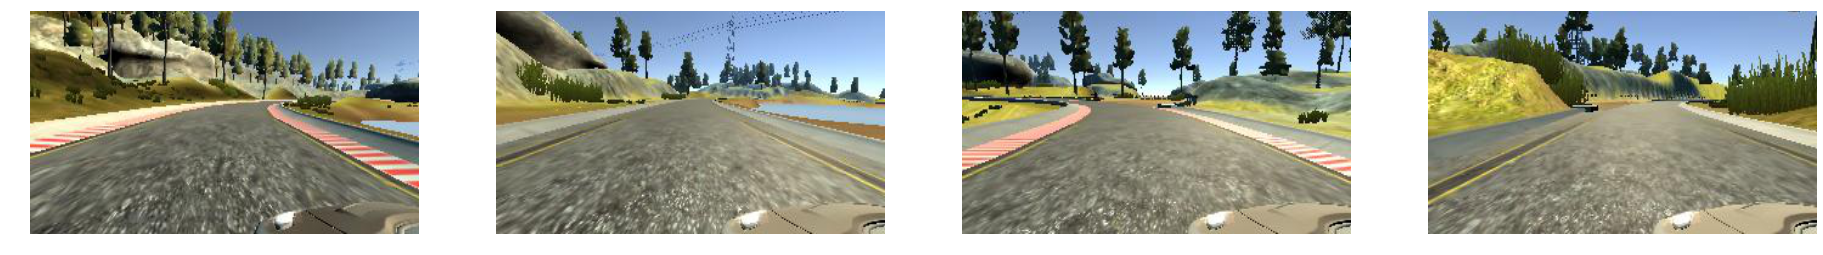

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random, os

%matplotlib inline

path = r"data/IMG/"
random_filename = [None] * 4
plt.rcParams['figure.figsize'] = (32, 4)
for i in range(4):
    random_filename[i] = random.choice([x for x in os.listdir(path) if os.path.isfile(os.path.join(path, x))])
    image = mpimg.imread(path+random_filename[i])
    plt.subplot(1, 4, i+1)
    plt.imshow(image, aspect='auto')
    plt.axis('off')

### Track 1 Observations
1. Daylight and good visibility.
1. Dry road surface.
1. Mainly level elevation.
1. Road has combination of straight, left and right turns.
1. Mostly well marked road edges.
1. Top ~= 25% of image is scenery, bottom ~= 15% is of car bonnet.

---
## 3. Summarise Dataset

---

In [2]:
import pandas as pd
data_frame = pd.read_csv('data/driving_log.csv', index_col=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2dd9a44590>]], dtype=object)

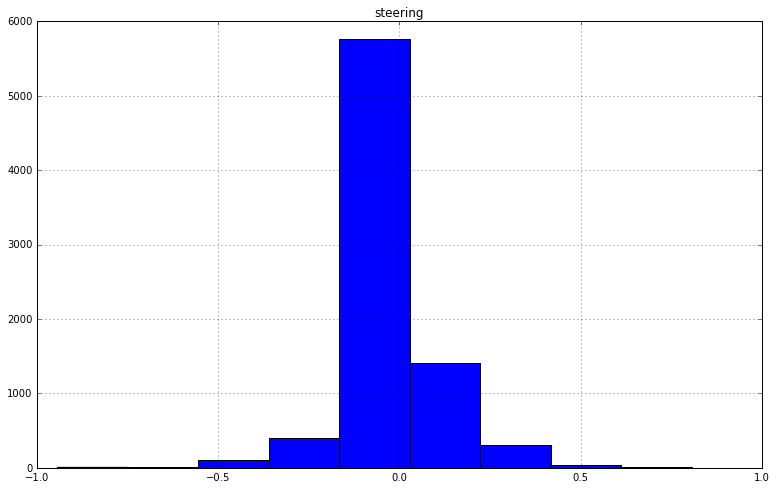

In [3]:
data_frame.hist(column='steering', figsize=(13,8))

* Steering angles skewed to the left aka more left turns than right.

In [14]:
# data_frame.describe()
data_frame.describe(include='all')

,center,left,right,steering,throttle,brake,speed
count,8036,8036,8036,8036.000000,8036.000000,8036.000000,8036.000000
unique,8036,8036,8036,NaN,NaN,NaN,NaN
top,IMG/center_2016_12_01_13_45_44_512.jpg,IMG/left_2016_12_01_13_42_04_035.jpg,IMG/right_2016_12_01_13_46_38_497.jpg,NaN,NaN,NaN,NaN
freq,1,1,1,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.004070,0.869660,0.001970,28.169839
std,NaN,NaN,NaN,0.128840,0.301326,0.036565,6.149327
min,NaN,NaN,NaN,-0.942695,0.000000,0.000000,0.502490
25%,NaN,NaN,NaN,0.000000,0.985533,0.000000,30.183093
50%,NaN,NaN,NaN,0.000000,0.985533,0.000000,30.186400
75%,NaN,NaN,NaN,0.000000,0.985533,0.000000,30.186640


1. 3 x camera images available ; center, left and right.
1. 8036 un-processed, un-augmented images.
1. 4 x telemetry 'labels' from actuators ; steering, throttle, brake, speed. Will only use steering for this project.

In [15]:
data_frame.head(100)

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.000000,0.000000,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.000000,0.000000,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.000000,0.000000,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.000000,0.000000,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.000000,0.000000,0.0,1.418236
5,IMG/center_2016_12_01_13_31_13_279.jpg,IMG/left_2016_12_01_13_31_13_279.jpg,IMG/right_2016_12_01_13_31_13_279.jpg,0.000000,0.000000,0.0,1.403993
6,IMG/center_2016_12_01_13_31_13_381.jpg,IMG/left_2016_12_01_13_31_13_381.jpg,IMG/right_2016_12_01_13_31_13_381.jpg,0.000000,0.000000,0.0,1.389892
7,IMG/center_2016_12_01_13_31_13_482.jpg,IMG/left_2016_12_01_13_31_13_482.jpg,IMG/right_2016_12_01_13_31_13_482.jpg,0.000000,0.000000,0.0,1.375934
8,IMG/center_2016_12_01_13_31_13_584.jpg,IMG/left_2016_12_01_13_31_13_584.jpg,IMG/right_2016_12_01_13_31_13_584.jpg,0.000000,0.000000,0.0,1.362115
9,IMG/center_2016_12_01_13_31_13_686.jpg,IMG/left_2016_12_01_13_31_13_686.jpg,IMG/right_2016_12_01_13_31_13_686.jpg,0.000000,0.000000,0.0,1.348435


---
## 4. Pre-process Dataset


---

---
## n. Scratchpad
1. Split provided dataset into Training and Validation datasets.
1. run model.py

---